In [1]:
# Crypto prices' analysis
import requests
import json
import pandas as pd

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

In [2]:
# Function for CryptoCompare HistoMinute API request

def get_histominute_data(exchange):
    url = 'https://min-api.cryptocompare.com/data/histominute?fsym=ETH&tsym=BTC&limit=1440&aggregate=1&e={}'
    response = requests.post(url.format(exchange))
    data = json.loads(response.content)
    df = pd.DataFrame.from_dict(data["Data"], orient="columns")
    
    
    return pd.DataFrame(df)

In [44]:
# json list to pandas dataframe
exchange_data = {}
#exchanges = ['BITFINEX', 'BITTREX', 'POLONIEX', 'HITBTC', 'BINANCE', 'BITFLYER', 'GEMINI', 'YOBIT', 'LIVECOIN', 'EXMO', 'CRYPTOPIA']
#exchanges = ['BINANCE', 'BITFINEX', 'BITFLYER', 'BITTREX', 'CRYPTOPIA', 'EXMO', 'GEMINI', 'HITBTC', 'KRAKEN', 'POLONIEX', 'YOBIT'] #btc_eth
exchanges = ['POLONIEX', 'BITTREX', 'GDAX', 'KRAKEN', 'GEMINI']
for exchange in exchanges:
    exchange_data[exchange] = get_histominute_data(exchange)



In [45]:
exchange_data['POLONIEX'].head()

,close,high,low,open,time,volumefrom,volumeto
0,0.04754,0.04761,0.04754,0.04755,1510587960,61.48,2.92
1,0.04742,0.04759,0.04733,0.04754,1510588020,163.07,7.74
2,0.04733,0.04742,0.04728,0.04742,1510588080,203.02,9.61
3,0.04721,0.04733,0.04721,0.04733,1510588140,159.39,7.53
4,0.04728,0.04728,0.04721,0.04721,1510588200,142.40,6.73


In [46]:
# Function to merge dataframes into a single dataframe
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [47]:
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'close')

In [48]:
btc_usd_datasets.head()

,BITTREX,GDAX,GEMINI,KRAKEN,POLONIEX
0,0.04751,0.04747,0.04741,0.04727,0.04754
1,0.04750,0.04740,0.04765,0.04733,0.04742
2,0.04751,0.04740,0.04765,0.04733,0.04733
3,0.04737,0.04726,0.04727,0.04725,0.04721
4,0.04732,0.04725,0.04727,0.04724,0.04728


In [49]:
# Add DateTime Column
btc_usd_datasets["DATE"] = exchange_data['BITTREX']['time']

In [50]:
# Calculating difference series price data
sum = 0;
for exchange in exchanges:
    sum = sum+btc_usd_datasets[exchange]


In [51]:
# Calculating difference series price data
sum = 0;
for exchange in exchanges:
    sum = sum+btc_usd_datasets[exchange]


In [52]:
dt_new = btc_usd_datasets
dt_new['DATE'] = pd.to_datetime(dt_new['DATE'],unit='s')
dt_new.head()

,BITTREX,GDAX,GEMINI,KRAKEN,POLONIEX,DATE
0,0.04751,0.04747,0.04741,0.04727,0.04754,2017-11-13 15:46:00
1,0.04750,0.04740,0.04765,0.04733,0.04742,2017-11-13 15:47:00
2,0.04751,0.04740,0.04765,0.04733,0.04733,2017-11-13 15:48:00
3,0.04737,0.04726,0.04727,0.04725,0.04721,2017-11-13 15:49:00
4,0.04732,0.04725,0.04727,0.04724,0.04728,2017-11-13 15:50:00


In [53]:
dt_new['AVG'] = sum/(len(dt_new.columns)-1)
dt_new.tail()

,BITTREX,GDAX,GEMINI,KRAKEN,POLONIEX,DATE,AVG
1436,0.05056,0.05050,0.05060,0.0503,0.05050,2017-11-14 15:42:00,0.050492
1437,0.05062,0.05050,0.05060,0.0503,0.05054,2017-11-14 15:43:00,0.050512
1438,0.05062,0.05050,0.05060,0.0503,0.05060,2017-11-14 15:44:00,0.050524
1439,0.05063,0.05057,0.05068,0.0503,0.05060,2017-11-14 15:45:00,0.050556
1440,0.05063,0.05057,0.05068,0.0503,0.05060,2017-11-14 15:46:00,0.050556


In [54]:
# calculating MSE
dict_mse = {}

for exchange in exchanges:
    dict_mse[exchange] = ((dt_new[exchange] - dt_new['AVG']) ** 2).mean(axis=0)

dict_mse

{'BITTREX': 1.6176943789035428e-08,
 'GDAX': 9.6306703678001677e-09,
 'GEMINI': 1.5613557251908387e-08,
 'KRAKEN': 9.2320927133934686e-08,
 'POLONIEX': 1.3169990284524662e-08}

In [55]:
# MSE Dictionary to Dataframe
df_mse = pd.DataFrame.from_dict(dict_mse, orient='index')

In [56]:
df_mse.rename(columns={0:'error'})

,error
POLONIEX,1.316999e-08
BITTREX,1.617694e-08
GDAX,9.630670e-09
KRAKEN,9.232093e-08
GEMINI,1.561356e-08


In [57]:
df_mse = df_mse.rename(columns={0:'error'})

In [58]:
#Normalisation

max_value = df_mse['error'].max()
min_value = df_mse['error'].min()
df_mse['normError']=(df_mse['error'] - min_value) / (max_value - min_value)


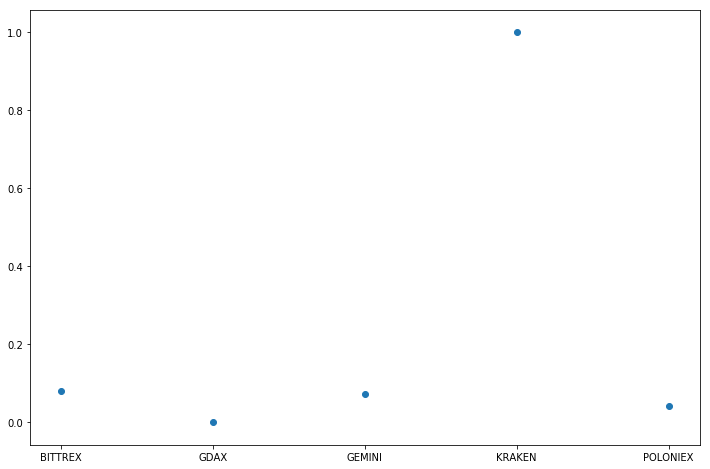

In [59]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

plt.scatter(df_mse.index, df_mse['normError'])